# シュレッダー復元問題の定式化

## 二次割当て問題としての定式化

### 定数とインデックス

- $N$: 紙片の総数
- $i,j \in [1,\dots,N]$: 位置を表すインデックス
- $a,b \in [1,\dots,N]$: 紙片を表すインデックス
- $d \in \{r, c\}$: 連結の方向
- $S_{abd}$: 紙片 $a$ と $b$ が方向 $d$ で連結した場合の類似度
- $D_{ijd}$: 位置 $i$ と $j$ が方向 $d$ でつながっているか否かのフラグ

### 変数

- $x_{ia}$: 位置 $i$ に紙片 $a$ が置かれている場合は $1$ となるフラグ

### 目的関数

$$
\max \sum_{abijd}S_{abd}D_{ijd}x_{ia}x_{jb}
$$

### 制約条件

- $\sum_{i}x_{ia} = 1$: 紙片 $a$ は、どこか一箇所にしか置かれない
- $\sum_{a}x_{ia} = 1$: 位置 $i$ における紙片は、1つである


## MIP への変形

$x_{ia}x_{jb}$を表す補助変数 $y_{ijab}$ を導入する

|$x_{ai}$|$x_{jb}$|$y_{ijab}$|
|:--:|:--:|:--:|
|0|0|0|
|0|1|0|
|1|0|0|
|1|1|1|

これは以下の制約で実現できる

- $x_{ia} + x_{jb} \leq y_{ijab} + 1$
- $x_{ia} \geq y_{ijab}$
- $x_{jb} \geq y_{ijab}$


In [12]:
import numpy as np
from functools import lru_cache
from collections import defaultdict
import pathlib
import pickle


def sim(a, b, d):
    if d == 'r':
        return (a[-1, :, :][:, :b.shape[1]] == b[0, :, :][:, :a.shape[1]]).sum()
    elif d == 'c':
        return (a[:, -1, :][:b.shape[0]] == b[:, 0, :][:a.shape[0]]).sum()
    else:
        raise


def total_cost(imgs, rows, cols):
    cost = 0
    n = rows*cols
    for i in range(len(imgs)):
        if (1 + 1)%cols > 0:
            cost += sim(imgs[i], imgs[i + 1], 'r')
        if i + cols < n:
            cost += sim(imgs[i], imgs[i + cols], 'c')
    return cost


def get_coeff(imgs, rows, cols):
    """
    \sum_{d}S_{abd}D_{ijd} を返す
    """
    n = rows*cols
    coeff = defaultdict(float)
    for a in range(len(imgs)):
        for b in range(len(imgs)):
            for i in range(rows*cols):
                if (i + 1)%cols > 0:
                    coeff[a, b, i, i + 1] = sim(imgs[a], imgs[b], 'c')
                if i + cols < n:
                    coeff[a, b, i, i + cols] = sim(imgs[a], imgs[b], 'r')
    return coeff

In [13]:
IMG_DIR = '../data/shred'

imgs = sorted(pathlib.Path(IMG_DIR).glob('*.pkl'))

In [14]:
with open(imgs[5], 'rb') as i_:
    data = pickle.load(i_)

print(data.rows, data.cols)

2 10


In [15]:
coeff = get_coeff(data.images, data.rows, data.cols)

In [16]:
data.indices

((0, 7),
 (1, 4),
 (0, 5),
 (1, 2),
 (0, 8),
 (1, 6),
 (1, 9),
 (1, 0),
 (0, 4),
 (0, 3),
 (1, 8),
 (1, 3),
 (0, 9),
 (1, 1),
 (0, 1),
 (1, 5),
 (0, 6),
 (0, 2),
 (1, 7),
 (0, 0))

In [17]:
import pulp


problem = pulp.LpProblem(sense=pulp.LpMaximize)

x = np.array(pulp.LpVariable.matrix('x', (range(data.size), range(data.size)), cat=pulp.LpBinary))
y = np.array(pulp.LpVariable.matrix('y', (range(data.size), range(data.size), range(data.size), range(data.size)), cat=pulp.LpBinary))

problem.setObjective(pulp.lpSum(
    coeff[a, b, i, j]*y[a, b, i, j] if coeff[a, b, i, j] != 0 else 0
    for a in range(data.size)
    for b in range(data.size)
    for i in range(data.size)
    for j in range(data.size)
    if i != j
))

for i in range(data.size):
    problem.addConstraint(pulp.lpSum(x[:, i]) == 1)

for a in range(data.size):
    problem.addConstraint(pulp.lpSum(x[a, :]) == 1)

for a, b, i, j in coeff.keys():
    if coeff[a, b, i, j] != 0:
        problem.addConstraint(x[a, i] + x[b, j] <= y[a, b, i, j] + 1)
        problem.addConstraint(x[a, i] >= y[a, b, i, j])
        problem.addConstraint(x[b, j] >= y[a, b, i, j])

In [22]:
solver = pulp.PULP_CBC_CMD(timeLimit=10*60*4, threads=4)

%time problem.solve(solver)

CPU times: user 290 ms, sys: 38.7 ms, total: 329 ms
Wall time: 10min 47s


1

In [23]:
results_x = np.vectorize(lambda x: x.value())(x)
patches = {}

for i in range(data.rows):
    for j in range(data.cols):
        idx = i*data.cols + j
        patches[i, j] = np.argmax(results_x[:, idx])

for i in range(data.rows):
    for j in range(data.cols):
        idx = i*data.cols + j
        if j < data.cols - 1:
#            s1 = sim(data.images[patches[i, j]], data.images[patches[i, j + 1]], 'c')
            s1 = coeff[patches[i, j], patches[i, j + 1], idx, idx + 1]
        else:
            s1 = 0
        if i < data.rows - 1:
#            s2 = sim(data.images[patches[i, j]], data.images[patches[i + 1, j]], 'r')
            s2 = coeff[patches[i, j], patches[i + 1, j], idx, idx + data.cols]
        else:
            s2 = 0
        print(f'({i}, {j}): {patches[i, j]}, coeff: {s1}, {s2}')

(0, 0): 3, coeff: 360, 0
(0, 1): 11, coeff: 676, 0
(0, 2): 7, coeff: 469, 0
(0, 3): 1, coeff: 2, 0
(0, 4): 17, coeff: 283, 0
(0, 5): 8, coeff: 183, 98
(0, 6): 0, coeff: 514, 0
(0, 7): 12, coeff: 213, 0
(0, 8): 2, coeff: 1, 17
(0, 9): 13, coeff: 0, 0
(1, 0): 4, coeff: 157, 0
(1, 1): 18, coeff: 383, 0
(1, 2): 6, coeff: 177, 0
(1, 3): 16, coeff: 77, 0
(1, 4): 10, coeff: 5, 0
(1, 5): 9, coeff: 650, 0
(1, 6): 19, coeff: 432, 0
(1, 7): 14, coeff: 3, 0
(1, 8): 5, coeff: 297, 0
(1, 9): 15, coeff: 0, 0


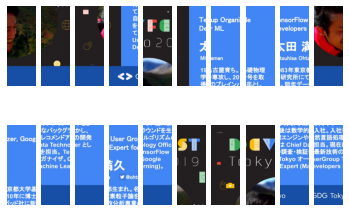

In [24]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(data.size):
    patch = data.images[np.argmax(results_x[:, i])]
    ax = fig.add_subplot(data.rows, data.cols, i + 1)
    ax.axis('off')
    ax.imshow(patch)